## Chapter 8
# DFT Applications

## Spectrum Analysis of a Sinusoid: WIndowing, Zero-Padding, and FFT

In [1]:
import numpy as np
import matplotlib.pyplot as plt

_Adapted from Example 1 on p166:_

In [2]:
def plot_signal_and_spectrum(x, x_sampled=None, title='', sample_spectrum=False):
    if x_sampled is None:
        x_sampled = x

    N = x_sampled.size
    X = np.fft.fft(x_sampled if sample_spectrum else x)

    plt.figure(figsize=(10, 8))
    plt.subplot(311)
    if sample_spectrum:
        plt.plot(n, x_sampled, '*k')
    plt.plot(np.linspace(0, N, x.size, endpoint=False), x, '-k')
    plt.xlim(0, N)
    plt.title(title)
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    
    mag_X = np.abs(X)
    fn = np.linspace(0, 1, N, endpoint=False)
    plt.subplot(312)
    if sample_spectrum:
        plt.stem(fn, mag_X, linefmt='k', markerfmt='ok', basefmt='k')
    else:
        plt.plot(fn, mag_X, '-k')
    plt.xlim(0, 1)
    plt.grid(True)
    plt.xlabel('Normalized Frequency (cycles per sample)')
    plt.ylabel('Magnitude (Linear)')
    
    # Same thing on a dB scale:
    spec = 20 * np.log10(mag_X)
    spec = np.maximum(spec, -40) # clip below -40 dB
    plt.subplot(313)
    plt.grid(True)
    plt.plot(fn, spec, '--ok' if sample_spectrum else '-k')
    plt.xlim(0, 1)
    plt.xlabel('Normalized Frequency (cycles per sample)')
    plt.ylabel('Magnitude (dB)')
    plt.tight_layout()

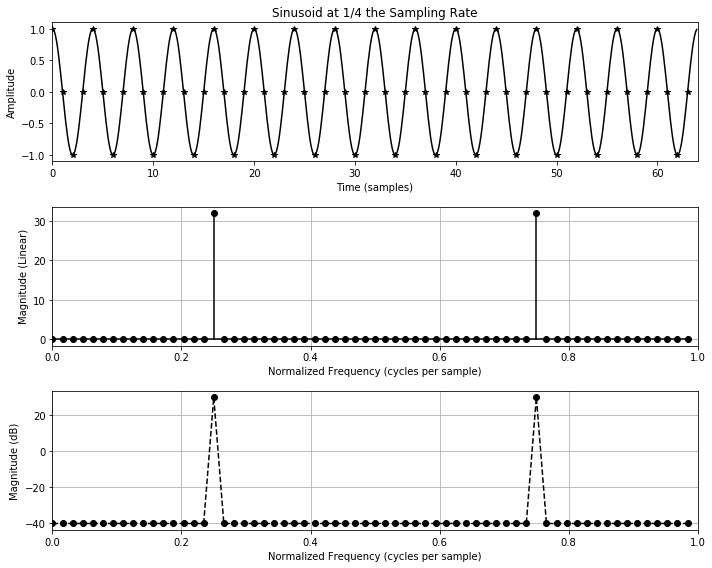

In [3]:
N = 64            # must be a power of two
T = 1             # sampling rate
A = 1             # sinusoidal amplitude
phi = 0           # sinusoidal phase
f = 1/4           # frequency (cycles/sample)
n = np.arange(N)  # discrete time axis
ni = np.arange(0, N, 0.1)
x = A * np.cos(2*np.pi*ni*f*T + phi) # sampled sinusoid
x_sampled = x[::10]
title = 'Sinusoid at 1/4 the Sampling Rate'

plot_signal_and_spectrum(x, x_sampled, title, sample_spectrum=True)

### FFT of a Not-So-Simple Sinusoid

_Adapted from p169:_

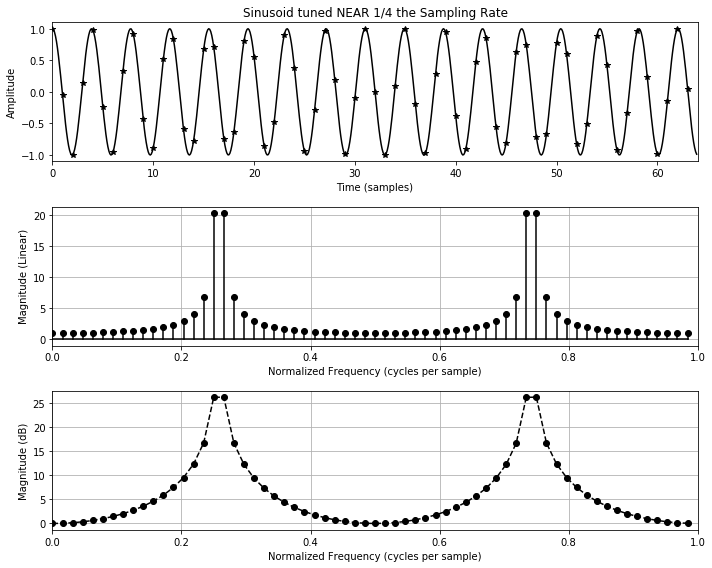

In [4]:
f = 1/4 + 0.5/N   # move frequency up 1/2 bin
x = A * np.cos(2*np.pi*ni*f*T + phi) # sampled sinusoid
x_sampled = x[::10]
title = 'Sinusoid tuned NEAR 1/4 the Sampling Rate'

plot_signal_and_spectrum(x, x_sampled, title, sample_spectrum=True)

At this frequency, we get extensive "spectral leakage" into all the bins. To get an idea of where this is coming from, let's look at the _periodic extension_ of the time waveform:

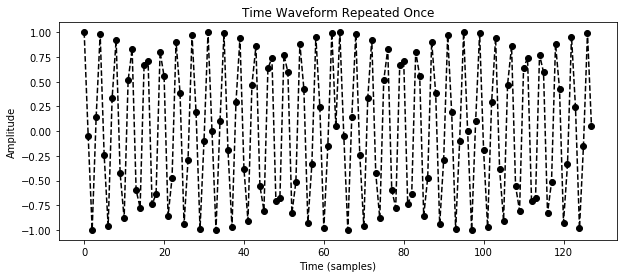

In [5]:
plt.figure(figsize=(10, 4))
plt.plot(np.append(x_sampled, x_sampled), '--ok')
plt.title('Time Waveform Repeated Once')
plt.xlabel('Time (samples)')
_ = plt.ylabel('Amplitude')

Note the "glitch" in the middle where the signal begins its forced repetition.

### FFT of a Zero-Padded Sinusoid

_Adapted from p170-171:_

We see above that there are no negative dB values. However, it is not true that the spectral magnitude at all frequencies is 1 or greater. To better see the true spectrum, let's use _zero padding_ in the time domain to give _ideal interpolation_ in the frequency domain:

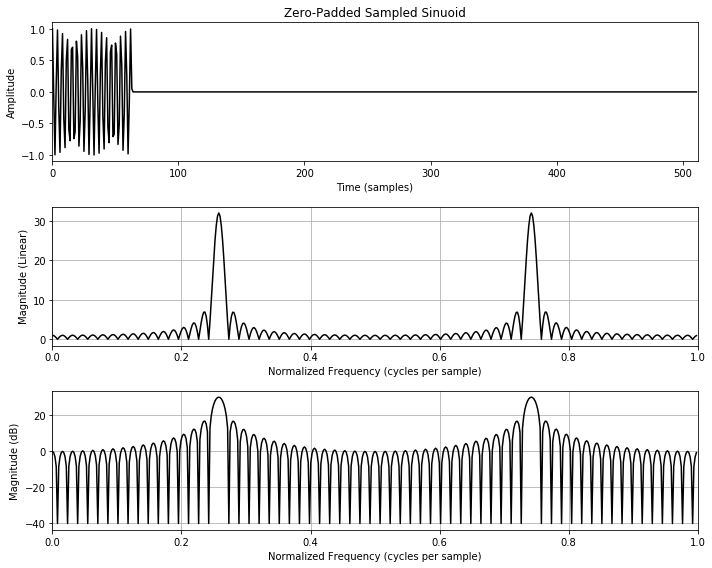

In [6]:
zero_padding_factor = 8
x = np.append(np.cos(2 * np.pi * n * f * T), np.zeros((zero_padding_factor - 1) * N))
plot_signal_and_spectrum(x, title='Zero-Padded Sampled Sinuoid', sample_spectrum=False)

### Use of a Blackman Window

_Adapted from p172-173:_

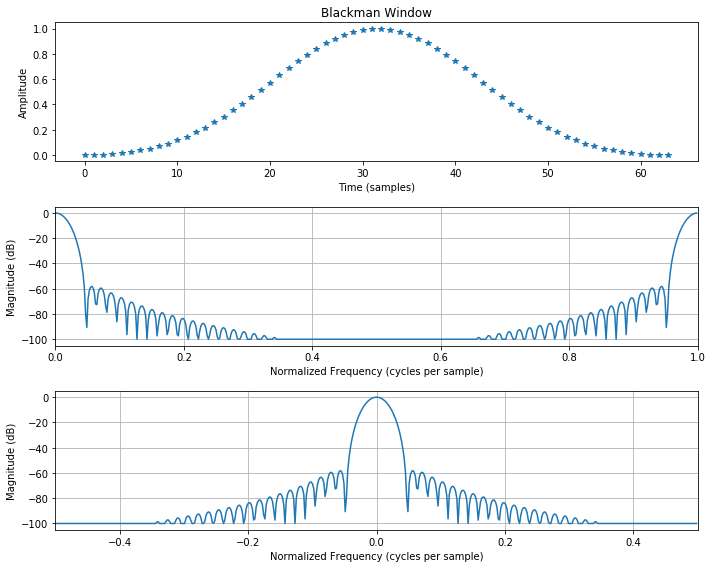

In [7]:
M = 64 # window size
w = np.blackman(M)

plt.figure(figsize=(10, 8))
plt.subplot(311)
plt.plot(w, '*')
plt.title('Blackman Window')
plt.xlabel('Time (samples)'); plt.ylabel('Amplitude');

# Also show the window transform:
zero_padding_factor = 8
xw = np.append(w, np.zeros((zero_padding_factor - 1) * M))
Xw = np.fft.fft(xw)
spec = 20 * np.log10(np.abs(Xw + 1e-30))
spec = spec - np.max(spec)
nfft = zero_padding_factor * M
spec = np.maximum(spec, -100)
fni = np.linspace(0, 1, nfft, endpoint=False)
plt.subplot(312)
plt.plot(fni, spec, '-')
plt.xlim(0,1)
plt.xlabel('Normalized Frequency (cycles per sample)')
plt.ylabel('Magnitude (dB)')
plt.grid(True)

# Replot  interpreting upper bin numbers as frequencies < 0:
nh = nfft // 2
specnf = np.append(spec[nh:nfft], spec[:nh]) # see np.fft.fftshift
fninf = fni - 0.5
plt.subplot(313)
plt.plot(fninf, specnf, '-')
plt.xlim(-0.5, 0.5)
plt.grid(True)
plt.xlabel('Normalized Frequency (cycles per sample)')
plt.ylabel('Magnitude (dB)')
plt.tight_layout()

### Applying the Blackman Window

Now let's apply the Blackman window to the sampled sinusoid and look at the effect on the spectrum analysis:

_Adapted from p175:_

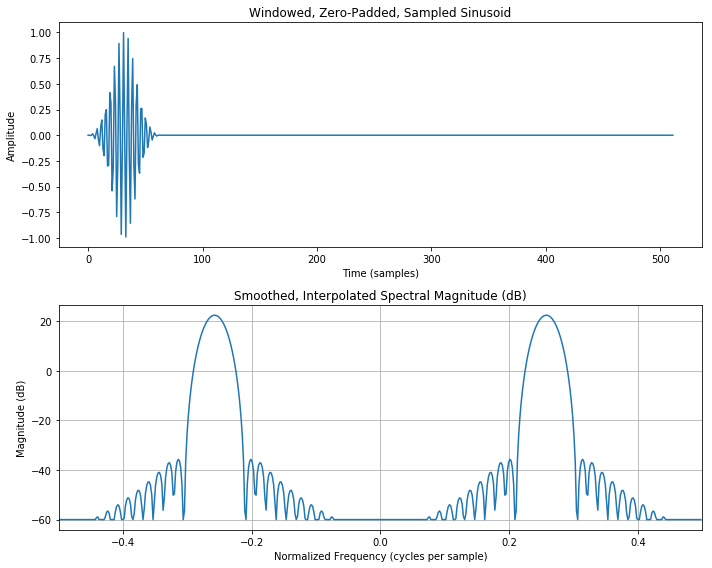

In [8]:
# Windowed, zero-padded data:
n = np.arange(M) # discrete time axis
f = 1/4 + 0.5/M # frequency
xw = np.append(w * np.cos(2 * np.pi * n * f), np.zeros((zero_padding_factor - 1) * M))
X = np.fft.fft(xw) # smoothed, interpolated spectrum

plt.figure(figsize=(10, 8))
plt.subplot(211)
plt.plot(xw)
plt.title('Windowed, Zero-Padded, Sampled Sinusoid')
plt.xlabel('Time (samples)'); plt.ylabel('Amplitude');

spec = 10 * np.log10(np.abs(X ** 2))
spec = np.maximum(spec, -60) # clip to -60 dB
plt.subplot(212)
plt.plot(fninf, np.fft.fftshift(spec), '-')
plt.xlim(-0.5, 0.5)
plt.title('Smoothed, Interpolated Spectral Magnitude (dB)')
plt.xlabel('Normalized Frequency (cycles per sample)')
plt.ylabel('Magnitude (dB)')
plt.grid(True)
plt.tight_layout()

### Hann-Windowed Complex Sinusoid

_Adapted from p177:_

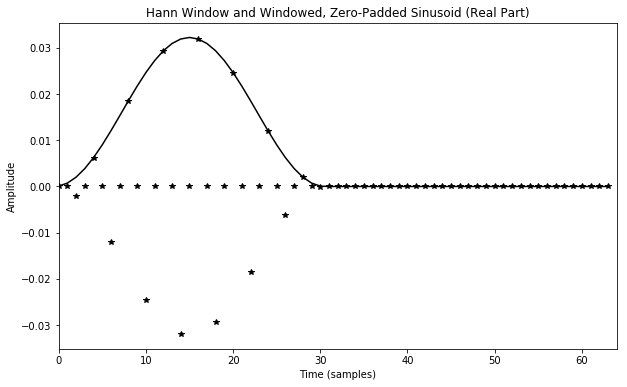

In [9]:
# Analysis parameters:
M = 31 # Window length
N = 64 # FFT length (zero padding factor near 2)

# Signal parameters:
wxT = 2 * np.pi / 4 # Sinusoid frequency (rad/sample)
A = 1 # Amplitude
phix = 0 # Phase

n = np.arange(N)
x = A * np.exp(1j*wxT*n + phix) # complex sine [1,j,-1,-j,...]

nm = np.arange(-(M - 1) // 2, (M + 1) // 2)
# Hann window = "raised cosine", normalization (1/M)
# chosen to give spectral peak magnitude at 1/2:
w = (1/M) * np.cos((np.pi / M) * nm) ** 2

wzp = np.append(w, np.zeros(N - M)) # zero-pad out to the length of x
xw = x * wzp # apply the window `w` to signal `x`

plt.figure(figsize=(10, 6))

plt.plot(n, wzp, '-k')
plt.plot(n, xw.real, '*k')
plt.xlim(0, N)
plt.title('Hann Window and Windowed, Zero-Padded Sinusoid (Real Part)')
plt.xlabel('Time (samples)')
_ = plt.ylabel('Amplitude')

### Hann Window Spectrum Analysis Results

_Adapted from p179:_

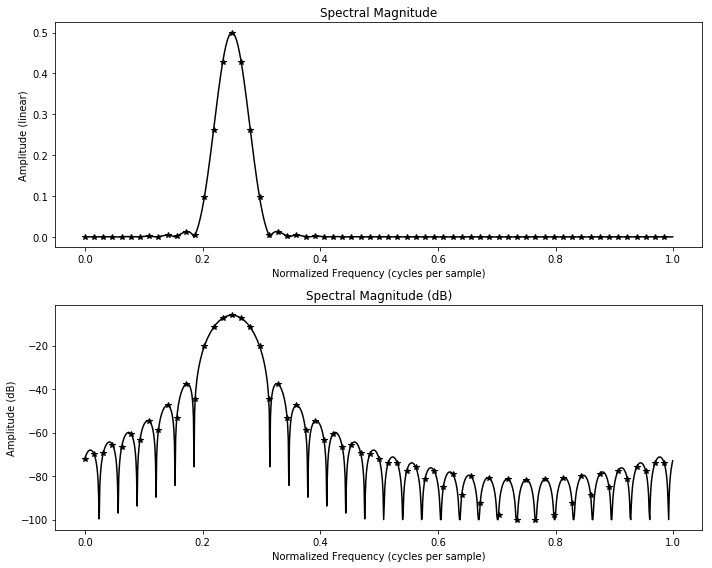

In [10]:
Xw = np.fft.fft(xw)
fn = np.linspace(0, 1, N, endpoint=False)
spec = 20 * np.log10(np.abs(Xw))
spec = np.maximum(spec, -100)
phs = np.angle(Xw)
phsu = np.unwrap(phs)

# Compute heavily interpolated versions for comparison:
zero_padding_factor = 16
Nfft = N * zero_padding_factor
xwi = np.append(xw, np.zeros(Nfft - N)) # zero-padded FFT buffer
Xwi = np.fft.fft(xwi)
fni = np.linspace(0, 1, Nfft, endpoint=False)
speci = 20 * np.log10(np.abs(Xwi))
speci = np.maximum(speci, -100)
phsi = np.angle(Xwi)
phsiu = np.unwrap(phsi)

plt.figure(figsize=(10, 8))
plt.subplot(211)

plt.plot(fn, np.abs(Xw), '*k')
plt.plot(fni, np.abs(Xwi), '-k')
plt.title('Spectral Magnitude')
plt.xlabel('Normalized Frequency (cycles per sample)')
plt.ylabel('Amplitude (linear)')

plt.subplot(212)
# Same thing on a dB scale
plt.plot(fn, spec, '*k')
plt.plot(fni, speci, '-k')
plt.title('Spectral Magnitude (dB)')
plt.xlabel('Normalized Frequency (cycles per sample)')
plt.ylabel('Amplitude (dB)')
plt.tight_layout()

_Adapted from p180:_

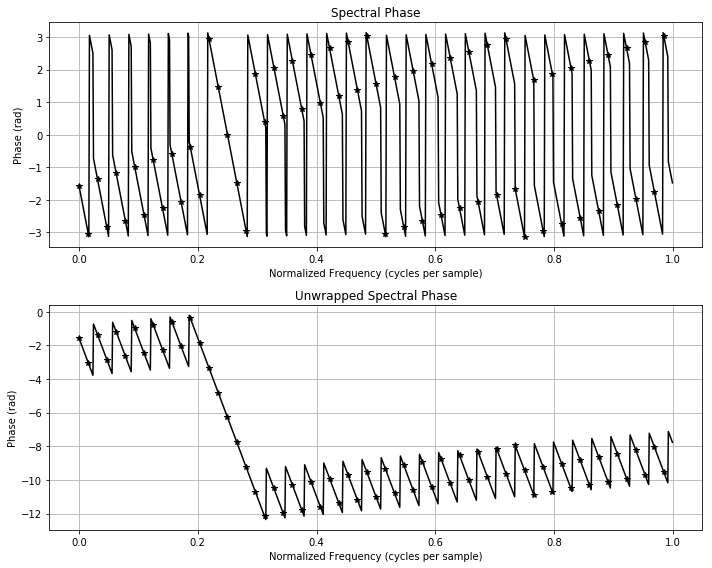

In [11]:
plt.figure(figsize=(10, 8))
plt.subplot(211)
plt.plot(fn, phs, '*k')
plt.plot(fni, phsi, '-k')
plt.title('Spectral Phase')
plt.xlabel('Normalized Frequency (cycles per sample)')
plt.ylabel('Phase (rad)')
plt.grid(True)

plt.subplot(212)
plt.plot(fn, phsu, '*k')
plt.plot(fni, phsiu, '-k')
plt.title('Unwrapped Spectral Phase')
plt.xlabel('Normalized Frequency (cycles per sample)')
plt.ylabel('Phase (rad)')
plt.grid(True)
plt.tight_layout()

## FIR System Identification

Estimating an impulse response from input-output measurements is called _system identification_. Cross-correlation can be used to compute the impulse response $h(n)$ of a filter from the cross-correlation of its input and output signals $x(n)$ and $y = h * x$, respectively. To see this, note that, by the correlation theorem,

$x \star y \longleftrightarrow \overline{X}\cdot Y = \overline{X} \cdot (H \cdot X) = H \cdot \left|X\right|^2$.

Therefore, the frequency response equals the input-output cross-spectrum divided by the input power spectrum:

$H = \frac{\overline{X} \cdot Y}{\left|X\right|^2} = \frac{\hat{R}_{xy}}{\hat{R}_{xx}}$

Impulse Response Error = 0.00000000000030%


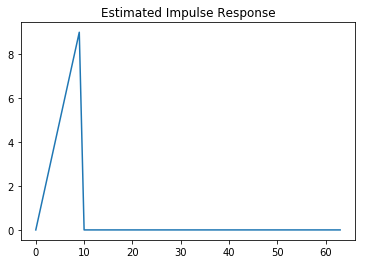

In [12]:
Nx = 32 # input signal length
Nh = 10 # filter length Ny = Nx + Nh - 1
Nfft = int(2 ** np.ceil(np.log2(Nx + Nh - 1))) # FFT wants power of 2

x = np.random.rand(Nx)
h = np.arange(Nh) # the filter (ramp)
xzp = np.append(x, np.zeros(Nfft - Nx)) # zero-padded input
yzp = np.convolve(xzp, h)[:Nfft] # apply the filter
X = np.fft.fft(xzp) # input spectrum
Y = np.fft.fft(yzp) # output spectrum
Rxx = np.conj(X) * X # energy spectrum of x
Rxy = np.conj(X) * Y # cross-energy spectrum
Hxy = Rxy / Rxx # should be the freq. response
hxy = np.fft.ifft(Hxy) # should be the imp. response

plt.plot(hxy.real)
plt.title('Estimated Impulse Response')
err = np.linalg.norm(hxy - np.append(h, np.zeros(Nfft - Nh))) / np.linalg.norm(h)
print('Impulse Response Error = %0.14f%%' % (100.0 * err))

## Coherence Function

The coherence is a real functino between zero and one which gives a _measure of correlation_ between _x_ and _y_ at each frequency $\omega$.

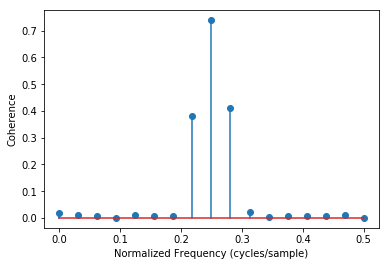

In [25]:
from scipy.signal import coherence

N = 1024
x = np.random.randn(N)
y = np.random.randn(N)
f0 = 1 / 4
nT = np.arange(N)
w0 = 2 * np.pi * f0
x = x + np.cos(w0 * nT)
p = 2 * np.pi * np.random.randn()
y = y + np.cos(w0 * nT + p)
M = round(np.sqrt(N))
f, cxyM = coherence(x, y, window=np.hanning(M))

plt.stem(f, cxyM)
plt.xlabel('Normalized Frequency (cycles/sample)')
_ = plt.ylabel('Coherence')

_Compare to Figure 8.15 on p196._